## Predicting an individual's response to resistance training

The dataset contains RSEM-extracted transcript counts that have been normalised based on library size, and metadata of individuals containing details on height, weight, age, percentage change in muscle mass etc. The transcripts are baseline counts, ie counts obtained before commencement of exercise.
The percentage change in muscle mas is an engineered feature from the measured muscle mass before commencement of exercise, and at the end of the study periods. 
    
A python package containing functions used regularly was created and I will explain each function when its called

In [1]:
#Import needed packages
from Trainome import functions
from pathlib import Path
import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from lazypredict.Supervised import LazyClassifier
from sklearn.metrics import classification_report, ConfusionMatrixDisplay, confusion_matrix, mean_squared_error,accuracy_score, balanced_accuracy_score,f1_score, matthews_corrcoef
from sklearn.model_selection import train_test_split, GridSearchCV
from lightgbm import LGBMClassifier
import joblib
import optuna.integration.lightgbm as lgb
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import PassiveAggressiveClassifier
import shap
shap.initjs()


In [2]:
data_folder = Path("/Users\chidimmpe\OneDrive - Høgskolen i Innlandet\\Trainome_data\\")

#Load all the transcripts data
all_isoforms = functions.load_all_isoforms(data_folder/"all_data_cpm.csv")

all_isoforms

transcript_id,sample_id,ARF5-201,M6PR-201,ESRRA-201,FKBP4-201,NDUFAF7-201,FUCA2-201,CYP51A1-201,USP28-201,HSPB6-201,...,GATA2-213,UQCRHL-202,IFNGR1-215,FANCG-218,IL10RB-208,EPG5-219,PTK2-258,IRAK4-215,PHKB-218,IRF2-210
0,X1023WVLL11,1.93,26.20,19.72,47.77,13.21,4.78,2.58,50.06,627.34,...,0.33,1.49,6.89,0.00,0.79,0.71,0.00,3.49,6.45,0.00
1,X1023WVLR10,0.43,28.54,13.66,47.55,13.96,6.77,2.94,39.46,574.76,...,0.94,3.39,0.00,0.00,0.31,0.22,0.00,3.03,8.31,0.00
2,X102PostExcVLL14,5.03,23.80,21.58,50.96,18.78,6.08,8.91,60.46,630.50,...,1.15,2.87,0.00,1.18,0.34,0.79,1.15,1.95,0.00,0.42
3,X102PostExcVLR13,4.28,30.41,13.94,60.36,15.54,6.86,13.51,40.05,644.23,...,1.26,2.08,2.98,0.47,0.78,0.62,2.38,6.13,6.82,0.00
4,X102PreExcVLR12,2.67,34.85,14.33,51.13,10.01,5.53,9.84,70.93,538.28,...,1.61,1.71,1.46,0.00,1.72,0.23,3.19,4.61,2.72,1.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
613,X95.subj4sample3,6.97,34.42,27.49,45.54,15.68,7.20,4.22,64.58,284.73,...,0.85,0.50,2.86,0.00,1.09,0.00,9.32,1.87,2.09,0.28
614,X96.subj4sample6,6.32,25.09,26.43,34.06,12.81,5.39,3.54,46.37,211.74,...,1.71,0.12,3.33,0.50,0.52,0.28,2.84,2.49,2.72,0.17
615,X97.subj4sample8,4.68,28.82,14.43,32.73,11.38,4.32,0.49,52.14,188.12,...,0.96,0.17,0.39,0.31,0.72,0.48,7.04,2.20,3.57,0.11
616,X98.subj40sample7,4.62,26.14,24.12,46.64,17.07,4.85,4.78,44.12,167.49,...,0.72,0.16,1.75,0.41,1.00,0.28,4.66,3.14,3.09,0.41


In [3]:
#load the metadata.
metadata = pd.read_csv(data_folder/"metadata_as_used_in_baseline_prediction_modelling/all_metadata.csv")
metadata

,participant,sample_id,sex,condition,study,age,height,weight,pct_change,diagnosis,category
0,FP102,X102PreExcVLR12,female,RM30,copd,65.80,151.50,84.00,22.21,none,High_responder
1,FP102,X102PreExcVLR12,female,RM10,copd,65.80,151.50,84.00,17.24,none,High_responder
2,FP103,X103PreExcVLR23,male,RM10,copd,70.90,170.00,82.50,1.05,none,mid_responder
3,FP103,X103PreExcVLR23,male,RM30,copd,70.90,170.00,82.50,14.01,none,High_responder
4,FP105,X105PreExcVLR38,female,RM30,copd,67.00,162.50,65.00,12.05,none,mid_responder
...,...,...,...,...,...,...,...,...,...,...,...
222,FP6,FP6w0R,female,single,vol,21.80,156.00,50.00,-0.81,none,Low_responder
223,FP7,FP7w0L,male,multiple,vol,21.20,194.00,106.00,8.34,none,High_responder
224,FP7,FP7w0R,male,single,vol,21.20,194.00,106.00,11.31,none,High_responder
225,FP9,FP9w0L,male,single,vol,20.60,190.00,76.50,4.26,none,mid_responder


### Some details about the metadata
The dataset in this study contains three individual datasets; COPD, volume and contratrain.
For each individual dataset, I categorized the individuals into three (High responders, mid responders and low responders)

Individuals with percentage change in muscle mass (pct_change) at and above the 75th quartile were classified as "High_responders", those below the 75th quartile but above the 25th quartile were classified "mid_responders", while those at and below the 25th quartile were grouped as "low responders". 

This categorisation was done to (hopefully) introduce some level of "similarity" in the datasets as the methods of muscle measurements were different

In [4]:
#merge the metadata to the isoform data. 
#This should extract the ones matching the metadata dataset.
all_baseline_df = metadata.merge(all_isoforms, on = ["sample_id"])
#check for and remove missing values
all_baseline_df = all_baseline_df.dropna()
all_baseline_df

,participant,sample_id,sex,condition,study,age,height,weight,pct_change,diagnosis,...,GATA2-213,UQCRHL-202,IFNGR1-215,FANCG-218,IL10RB-208,EPG5-219,PTK2-258,IRAK4-215,PHKB-218,IRF2-210
0,FP102,X102PreExcVLR12,female,RM30,copd,65.80,151.50,84.00,22.21,none,...,1.61,1.71,1.46,0.00,1.72,0.23,3.19,4.61,2.72,1.00
1,FP102,X102PreExcVLR12,female,RM10,copd,65.80,151.50,84.00,17.24,none,...,1.61,1.71,1.46,0.00,1.72,0.23,3.19,4.61,2.72,1.00
2,FP103,X103PreExcVLR23,male,RM10,copd,70.90,170.00,82.50,1.05,none,...,1.20,5.73,0.00,0.91,1.18,0.00,4.59,3.01,0.00,0.00
3,FP103,X103PreExcVLR23,male,RM30,copd,70.90,170.00,82.50,14.01,none,...,1.20,5.73,0.00,0.91,1.18,0.00,4.59,3.01,0.00,0.00
4,FP105,X105PreExcVLR38,female,RM30,copd,67.00,162.50,65.00,12.05,none,...,1.34,5.97,0.00,0.66,0.74,0.20,2.91,4.02,5.72,0.61
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
222,FP6,FP6w0R,female,single,vol,21.80,156.00,50.00,-0.81,none,...,1.40,5.81,3.98,0.27,1.22,0.60,2.46,0.44,4.52,0.44
223,FP7,FP7w0L,male,multiple,vol,21.20,194.00,106.00,8.34,none,...,1.28,2.19,3.55,0.74,0.26,0.10,3.60,3.84,0.00,0.75
224,FP7,FP7w0R,male,single,vol,21.20,194.00,106.00,11.31,none,...,1.42,2.52,3.15,0.72,0.42,0.29,3.88,4.17,5.15,0.15
225,FP9,FP9w0L,male,single,vol,20.60,190.00,76.50,4.26,none,...,1.12,4.25,2.02,0.68,0.72,0.18,5.73,3.34,3.90,0.27


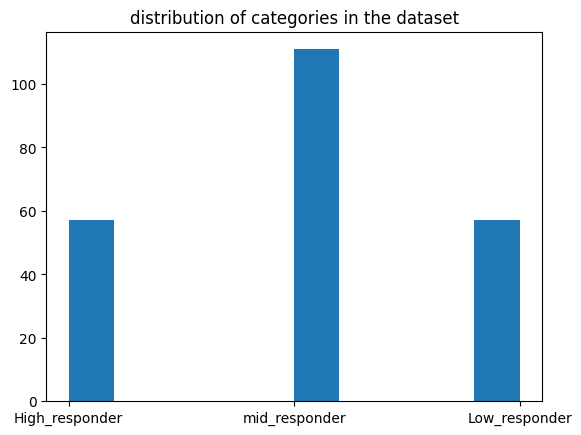

In [5]:
plt.hist(all_baseline_df["category"])
plt.title("distribution of categories in the dataset")
plt.show()

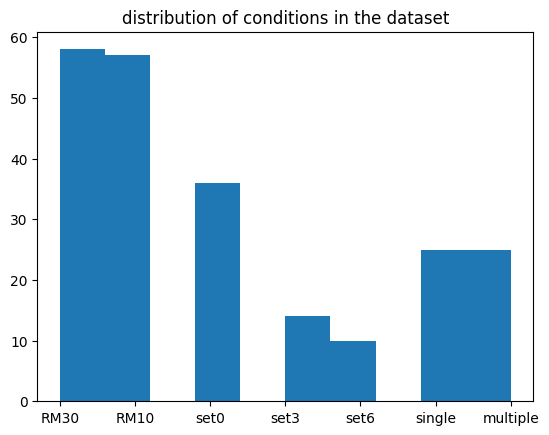

In [6]:
plt.hist(all_baseline_df["condition"])
plt.title("distribution of conditions in the dataset")
plt.show()

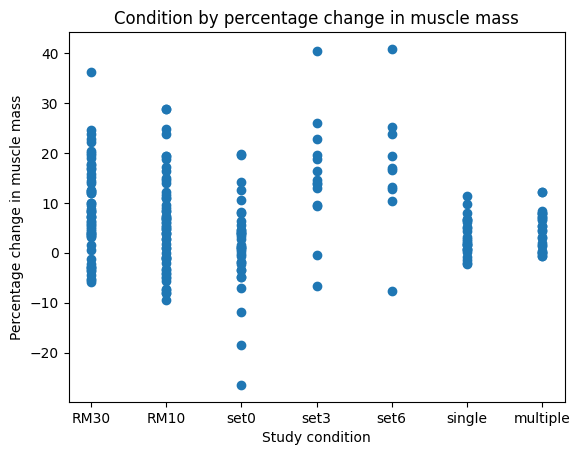

In [7]:
plt.scatter(all_baseline_df["condition"],all_baseline_df["pct_change"])
plt.xlabel('Study condition')
plt.ylabel('Percentage change in muscle mass')
plt.title('Condition by percentage change in muscle mass')
plt.show()

In [8]:
# initialize the X and y variables
#The predictor excludes the participants and sample ids, the category, diagnosis and percentage change variables.
#It also performs a log transformation and scaling of the predictor variables
X = functions.predictor_df(all_baseline_df)


y = functions.response_df(all_baseline_df)

## The predictor_df and response_df functions


#### def transform_and_scale(df):

    """function for transforming and scaling a dataset
    """
    
    transformer = FunctionTransformer(np.log1p, validate = True)
    
    scaler = StandardScaler()
    
    df_transformed = transformer.transform(df)
    
    df_transformed = pd.DataFrame(df_transformed, columns = df.columns.tolist(), index = df.index)
    
    df_transformed = scaler.fit_transform(df_transformed)
    
    df_transformed = pd.DataFrame(df_transformed, columns = df.columns.tolist(), index = df.index)
    
    #### return df_transformed




exc = ["participant", "sample_id",  "category", "pct_change",  "diagnosis"]



#### def predictor_df(df):

    """accepts as input a dataframe which containing the predictors
    to be exculded from the dataframe are variables in the list
    "exc" defined outside the function """
    
    X_class = df.drop(exc, axis = 1)
    
    #convert all_categorical variables to dummy variables
    
    X_class = pd.get_dummies(X_class)
    
    X_class = transform_and_scale(X_class)
    
   ####  return X_class
    
    
    
response= "category"

#### def response_df(df):

    """ accepts as input the column and dataframe containing
    the response variable
    """
    
    
   y_class = df[response]
   
   
   #### return y_class




### Choosing LGBMClassifier 
LazyClassifier ranked LGBMClassifier high in most cases so I chose to settle for LGBMClassifier. Besides, its predictions can be explained using shapTreeExplainer.

I attempted using optuna to optimised the hyperparameters and finally settled for the parameters used below

In [9]:
lgbm_clf = LGBMClassifier(random_state=123, num_leaves = 3,  objective = "multiclass")
lgbm_clf.fit(X, y)
y_pred=lgbm_clf.predict(X)

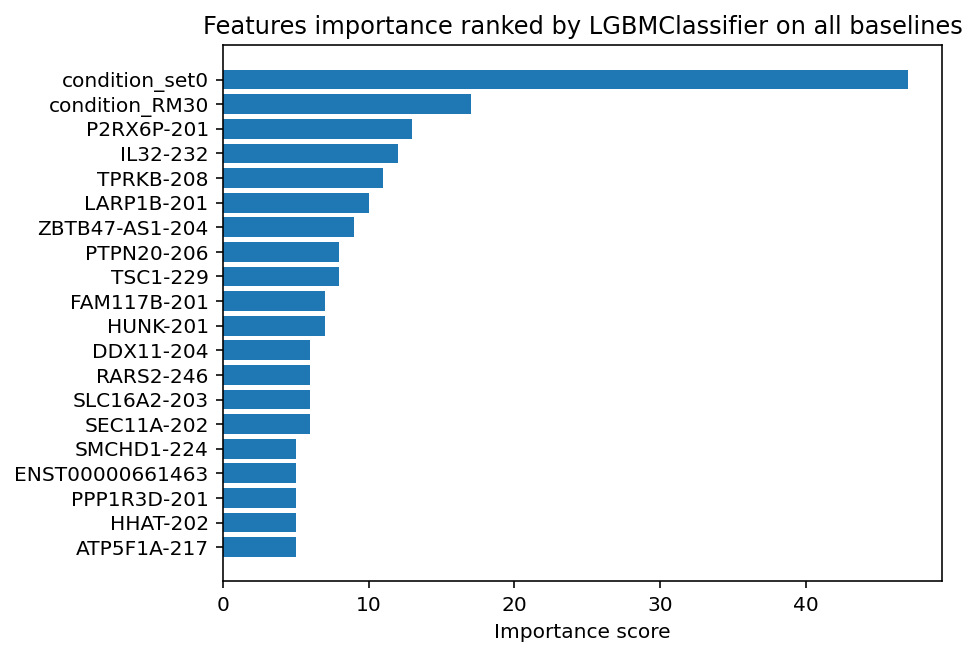

In [10]:
#Extract the important features in the LGBMClassifier object
all_baseline_imp = functions.imp_features(lgbm_clf)

# plot the top 20 important features 
top_20 = all_baseline_imp.iloc[-20:, :]
plt.title('Features importance ranked by LGBMClassifier on all baselines')
plt.xlabel('Importance score')
plt.gcf().set_dpi(145)
plt.barh(top_20['Features'],top_20['Importance_values'], height=0.8)
#plt.savefig(".\images\LGBMClassifier_top_20.png")
plt.show()

### Check the prediction metrics

In [11]:
print("Accuracy", accuracy_score(y, y_pred))
print("Balanced accuracy", balanced_accuracy_score(y, y_pred))
print('F1 score:',f1_score(y,y_pred,average='weighted'))
print('MCC:', matthews_corrcoef(y,y_pred))

print(confusion_matrix(y,y_pred))

Accuracy 0.8888888888888888
Balanced accuracy 0.8936304725778409
F1 score: 0.8894788201915227
MCC: 0.8257610603093013
[[53  2  2]
 [ 1 50  6]
 [ 4 10 97]]


 97%|=================== | 657/675 [00:19<00:00]       

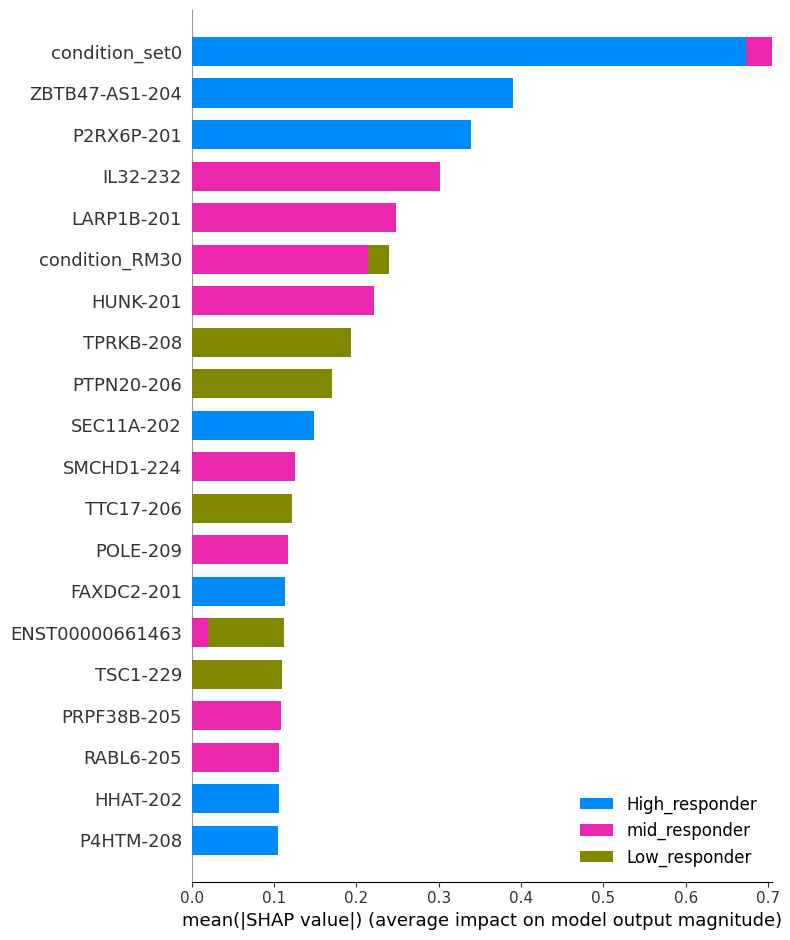

In [12]:
# Explainability using shap
explainer = shap.TreeExplainer(lgbm_clf,X)
shap_values = explainer.shap_values(X)
shap.summary_plot(shap_values,X,plot_type="bar", max_display=20, class_names=y.unique())

### Explaining the shap output
Not sure if it is how it works but I made the naming to be as follows

#### Class 0 = High-responders

#### Class 1 = mid_responders

#### Class 2 = Low responders.

This was made using the options "class_name = y.unique()". I have to figure out if the  naming is actually correct.

#### It would by default present the impact as shown below

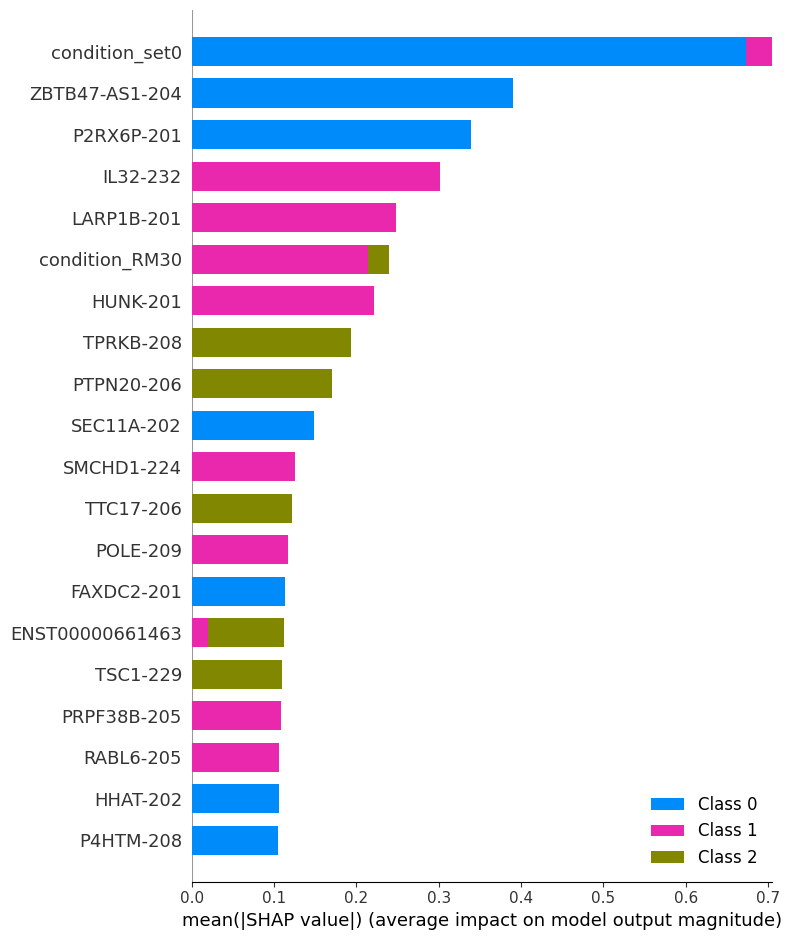

In [13]:
shap.summary_plot(shap_values,X,plot_type="bar", max_display=20)

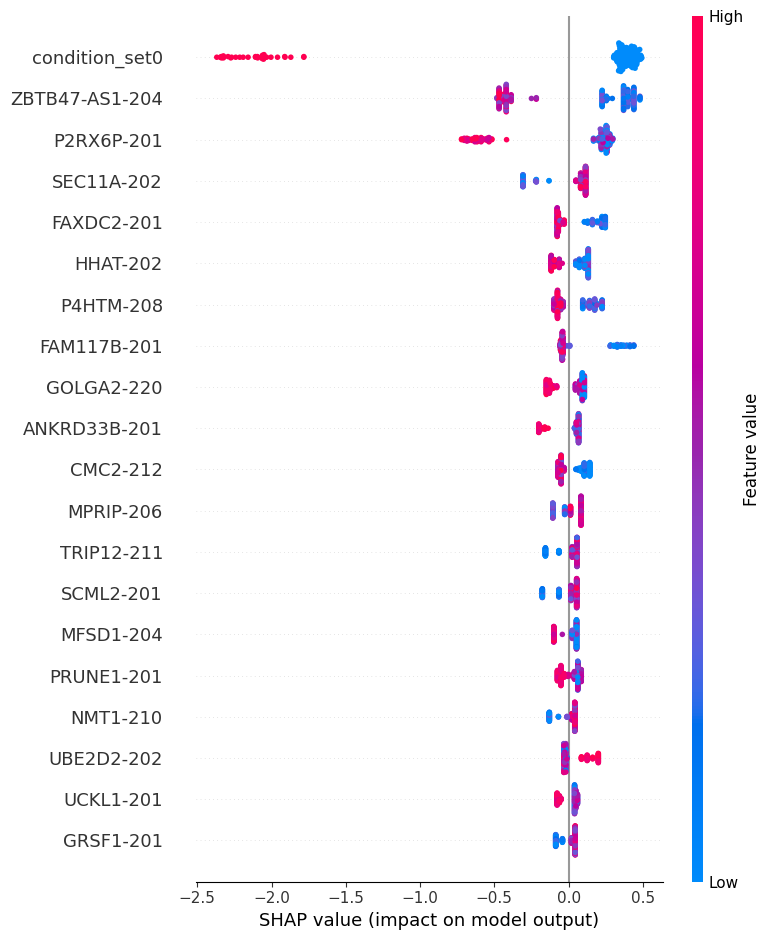

In [14]:
#Feature impact for High responders
shap.summary_plot(shap_values[0],X, max_display=20)


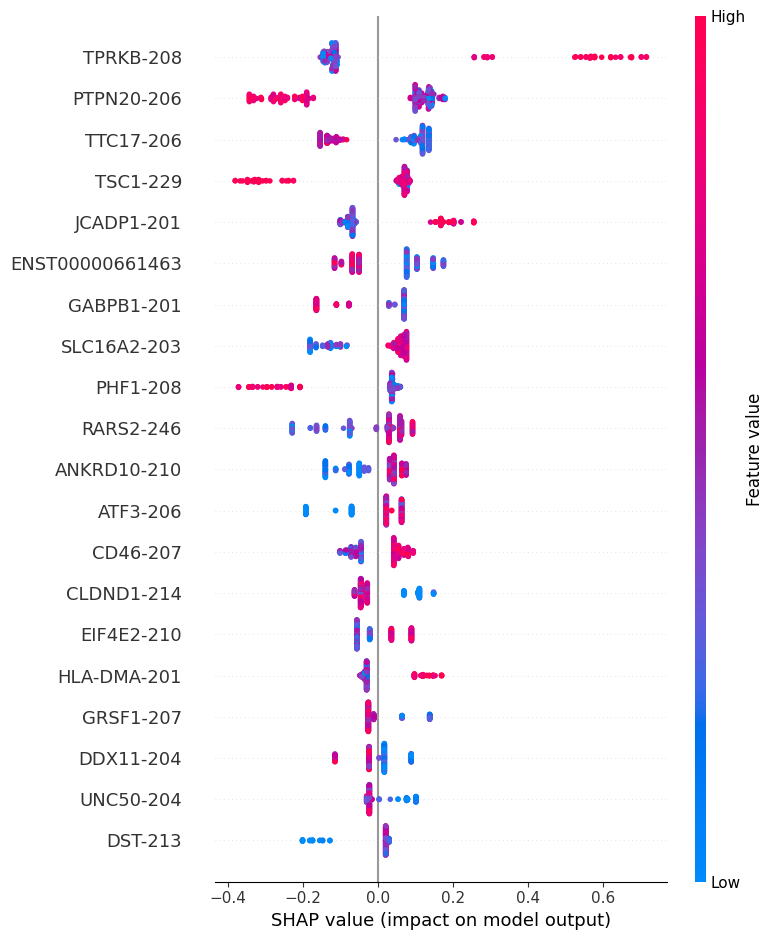

In [15]:
#Feature impact for low responders
shap.summary_plot(shap_values[2],X, max_display=20)

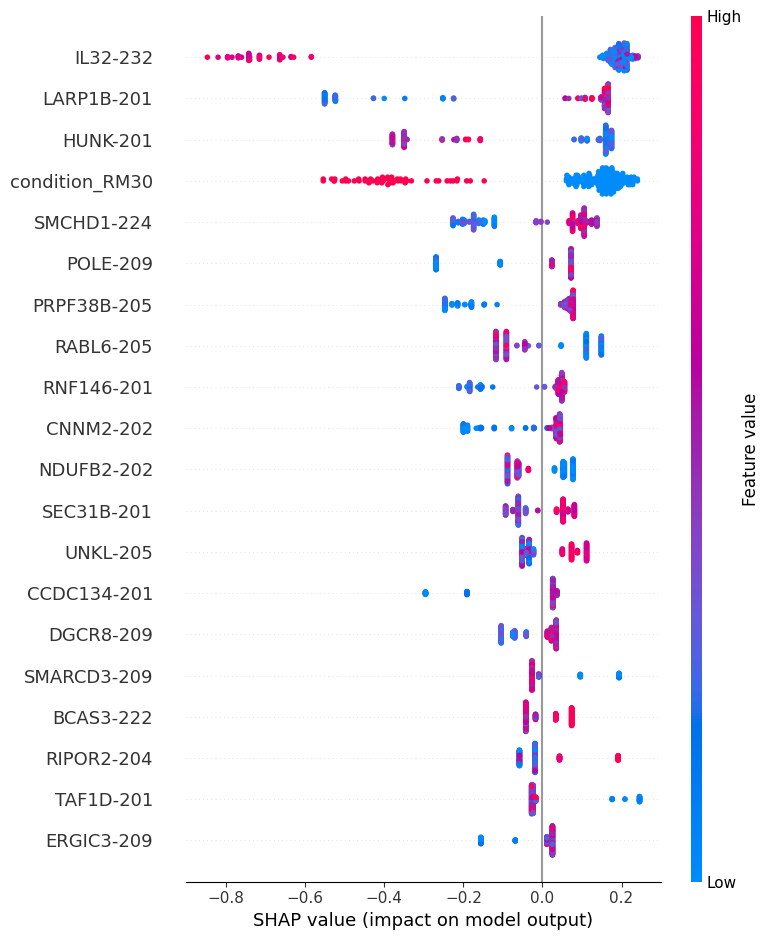

In [16]:
#Feature impact for low responders
shap.summary_plot(shap_values[1],X, max_display=20)

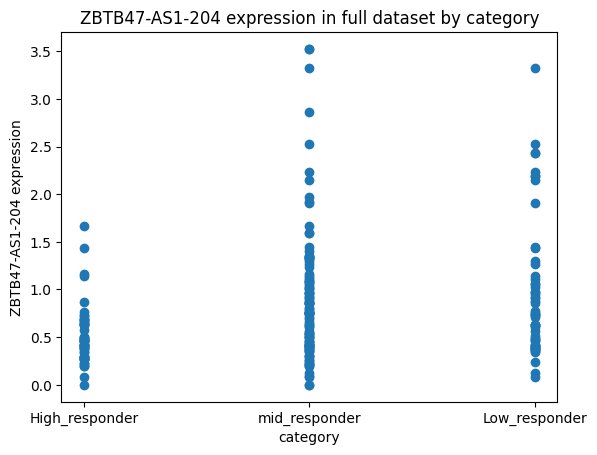

In [17]:
#View some important features 
plt.scatter(all_baseline_df["category"],all_baseline_df["ZBTB47-AS1-204"])
plt.ylabel('ZBTB47-AS1-204 expression')
plt.xlabel('category')
plt.title('ZBTB47-AS1-204 expression in full dataset by category')
plt.show()

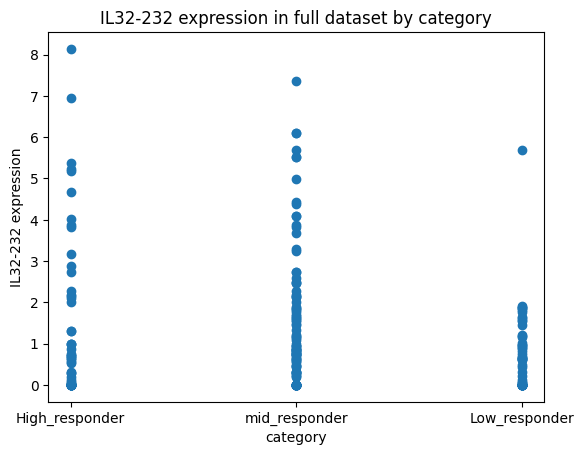

In [18]:
plt.scatter(all_baseline_df["category"],all_baseline_df["IL32-232"])
plt.ylabel('IL32-232 expression')
plt.xlabel('category')
plt.title('IL32-232 expression in full dataset by category')
plt.show()

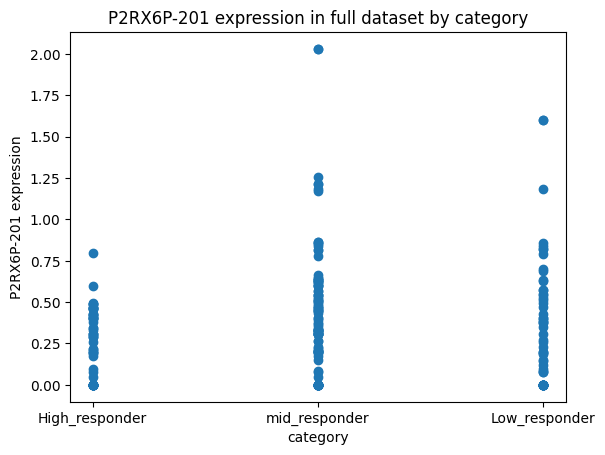

In [19]:
plt.scatter(all_baseline_df["category"],all_baseline_df["P2RX6P-201"])
plt.ylabel('P2RX6P-201 expression')
plt.xlabel('category')
plt.title('P2RX6P-201 expression in full dataset by category')
plt.show()

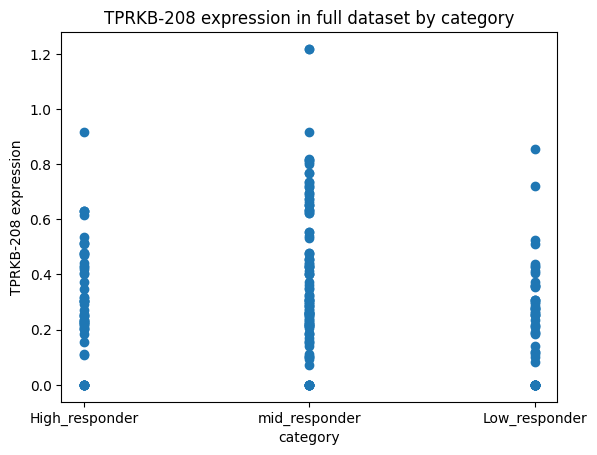

In [20]:
plt.scatter(all_baseline_df["category"],all_baseline_df["TPRKB-208"])
plt.ylabel('TPRKB-208 expression')
plt.xlabel('category')
plt.title('TPRKB-208 expression in full dataset by category')
plt.show()

In [21]:
# The important features in the classification and their importance values in ascending order
all_baseline_imp

,Features,Importance_values
14116,ERP29-202,1
9470,CNTROB-201,1
19346,SDHA-213,1
8170,ZFYVE9-204,1
2604,ESAM-201,1
...,...,...
17174,TPRKB-208,11
22907,IL32-232,12
13129,P2RX6P-201,13
32522,condition_RM30,17


### Perform binary classifications to  predict "high responders vs others", and "low responders versus others" using the same LGBMClassifier

In [22]:
# Phrase the classification as a 3 binary classification tasks

#y_train for the high responders category
y_high_cat = y.replace({"High_responder": 1, "mid_responder" :0, "Low_responder" : 0})

#y_train for middle responders category

y_mid_cat = y.replace({"High_responder": 0, "mid_responder" :1, "Low_responder" : 0})


#y_train for the low_responders category

y_low_cat = y.replace({"High_responder": 0, "mid_responder" :0, "Low_responder" : 1})

print("High_responders", y_high_cat.value_counts())
print("Mid responders", y_mid_cat.value_counts())
print("low responders" , y_low_cat.value_counts())


High_responders 0    168
1     57
Name: category, dtype: int64
Mid responders 0    114
1    111
Name: category, dtype: int64
low responders 0    168
1     57
Name: category, dtype: int64


## Predict for high responders versus others

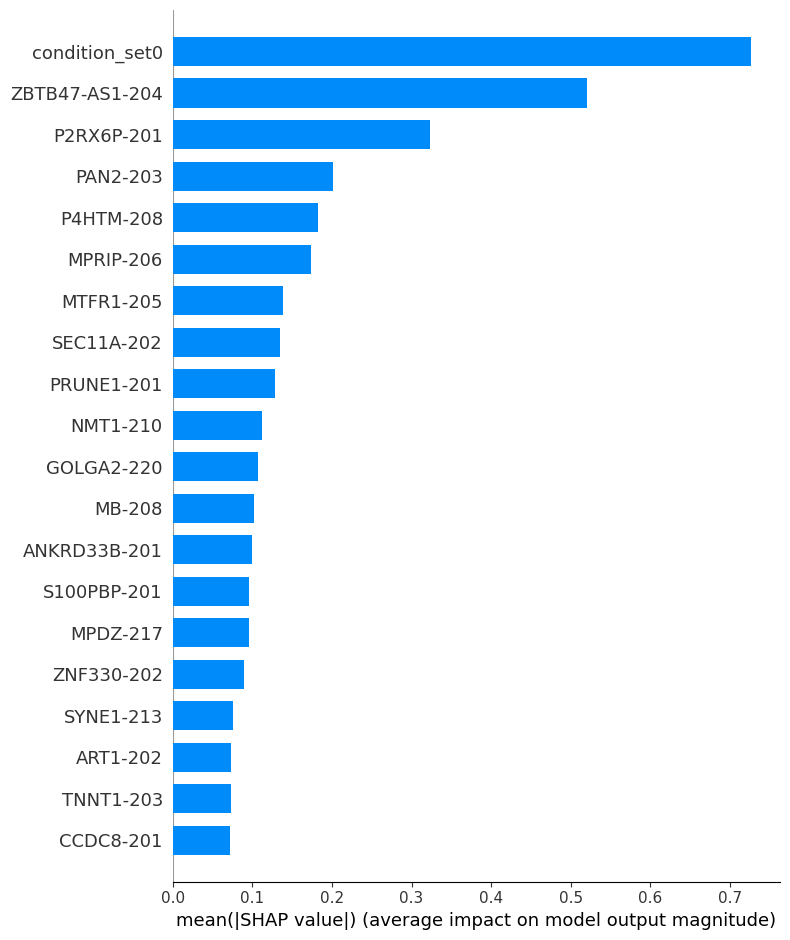

In [23]:
#predict on high responders 
lgbm_clf2 = LGBMClassifier(is_unbalance=True, num_leaves = 3, random_state=123)
lgbm_clf2.fit(X, y_high_cat)
y_pred=lgbm_clf2.predict(X)


#Explain the output using shap
explainer = shap.TreeExplainer(lgbm_clf2,X)
shap_values = explainer.shap_values(X)
shap.summary_plot(shap_values,X,plot_type="bar", max_display=20, class_names=y_high_cat.unique())



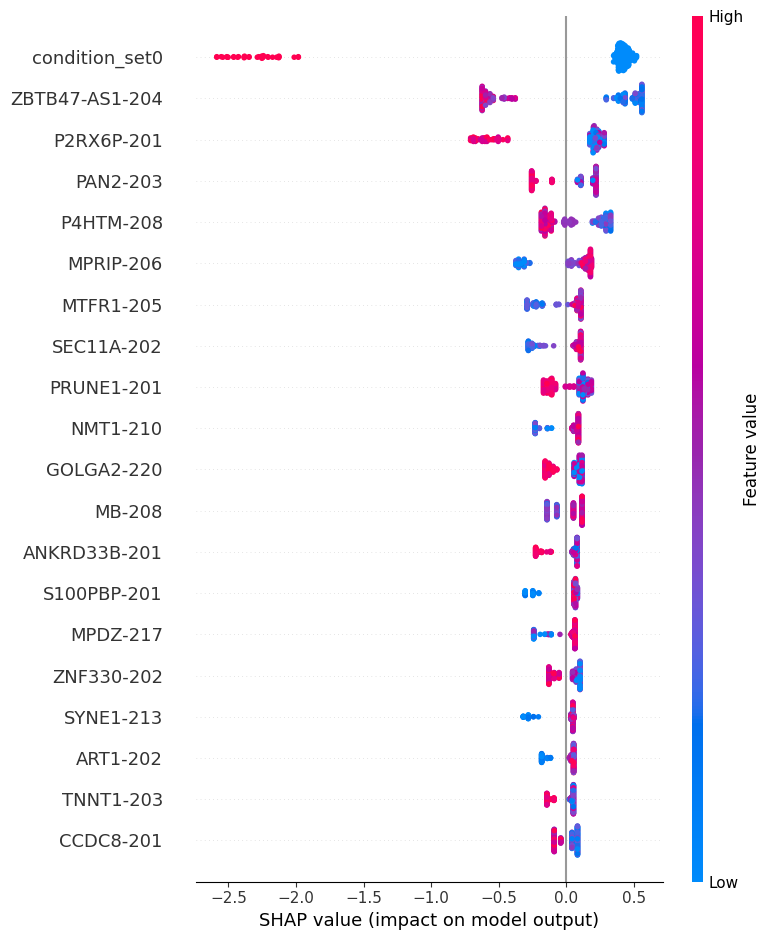

In [24]:
shap.summary_plot(shap_values,X, max_display=20, class_names=y_high_cat.unique())

In [25]:
print("Accuracy", accuracy_score(y_high_cat, y_pred))

print("Balanced accuracy", balanced_accuracy_score(y_high_cat, y_pred))
print('F1 score:',f1_score(y_high_cat,y_pred,average='weighted'))
print('MCC:', matthews_corrcoef(y_high_cat,y_pred))

print(confusion_matrix(y_high_cat,y_pred))


Accuracy 0.9422222222222222
Balanced accuracy 0.9613095238095238
F1 score: 0.9440166418826129
MCC: 0.8667615071079712
[[155  13]
 [  0  57]]


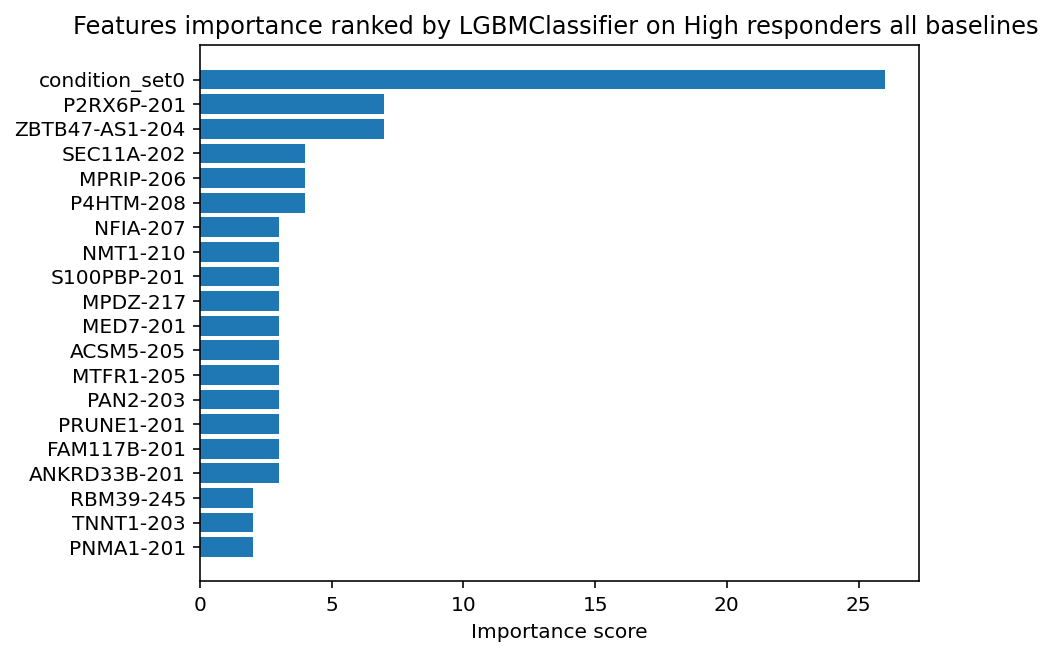

In [26]:
#Extract the important features in the high responders object
all_baseline_imp2 = functions.imp_features(lgbm_clf2)

# plot the top 20 important features 
top_20 = all_baseline_imp2.iloc[-20:, :]
plt.title('Features importance ranked by LGBMClassifier on High responders all baselines ')
plt.xlabel('Importance score')
plt.gcf().set_dpi(145)
plt.barh(top_20['Features'],top_20['Importance_values'], height=0.8)
plt.show()

## Predict for low responders versus others

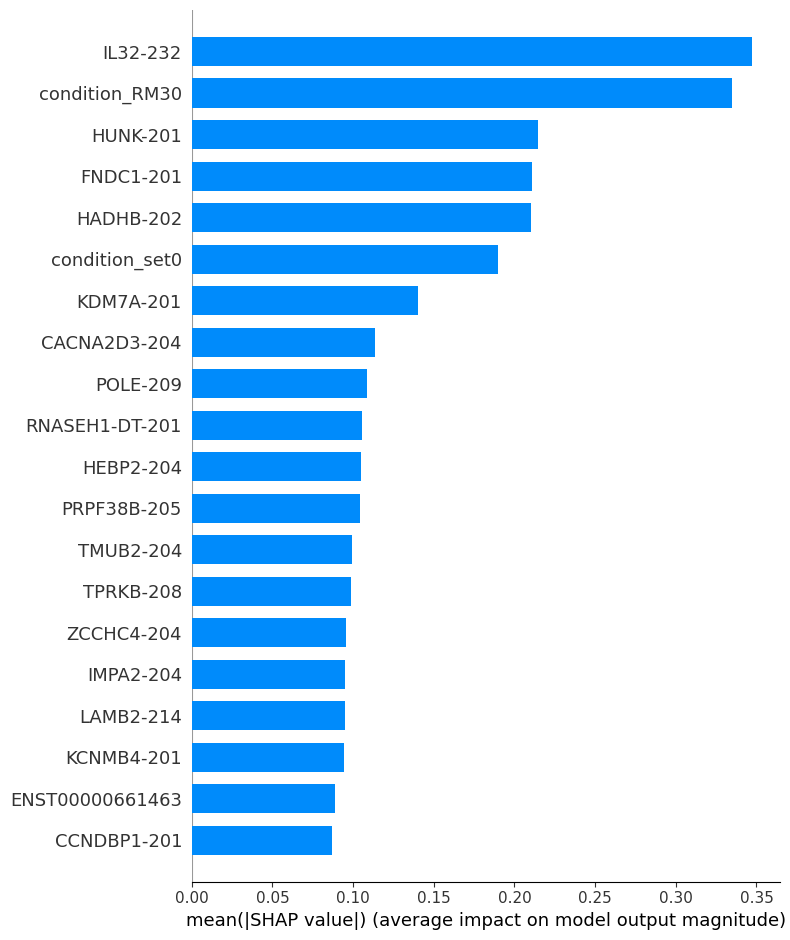

In [27]:
# predict on low responders
lgbm_clf4 = LGBMClassifier(is_unbalance=True,random_state=123, num_leaves = 3)
lgbm_clf4.fit(X, y_low_cat)
y_pred=lgbm_clf4.predict(X)


#Explain the output using shap
explainer = shap.TreeExplainer(lgbm_clf4,X)
shap_values = explainer.shap_values(X)
shap.summary_plot(shap_values,X,plot_type="bar", max_display=20, class_names=y_low_cat.unique())


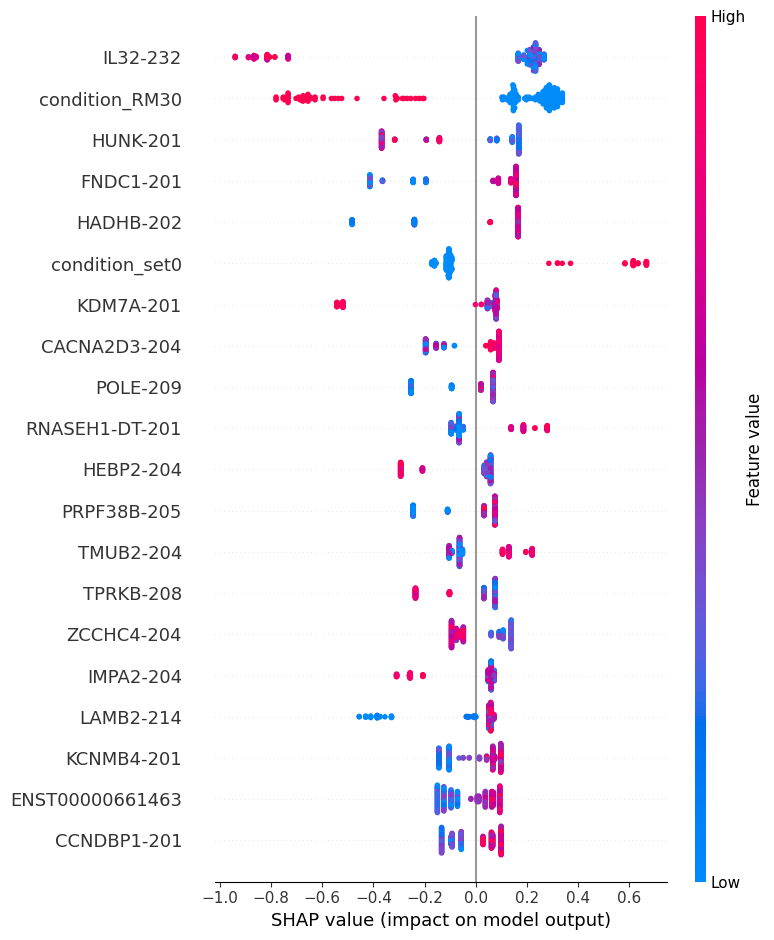

In [28]:
shap.summary_plot(shap_values,X,max_display=20, class_names=y_low_cat.unique())

IL232 seems to be important in predicting low responders. Could help to view a dependence plot.

Would be exploring this further

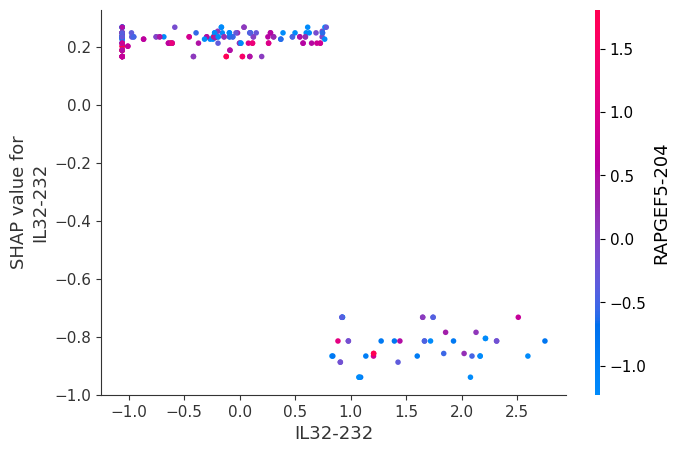

In [29]:
shap.dependence_plot("IL32-232", shap_values, X, show=False)

In [30]:
# Print the model metrics
print("Accuracy", accuracy_score(y_low_cat, y_pred))
print("Balanced accuracy", balanced_accuracy_score(y_low_cat, y_pred))

print('F1 score:',f1_score(y_low_cat,y_pred,average='weighted'))
print('MCC:', matthews_corrcoef(y_low_cat,y_pred))

print(confusion_matrix(y_low_cat,y_pred))

Accuracy 0.8977777777777778
Balanced accuracy 0.9315476190476191
F1 score: 0.9026027067154839
MCC: 0.7841908933052316
[[145  23]
 [  0  57]]


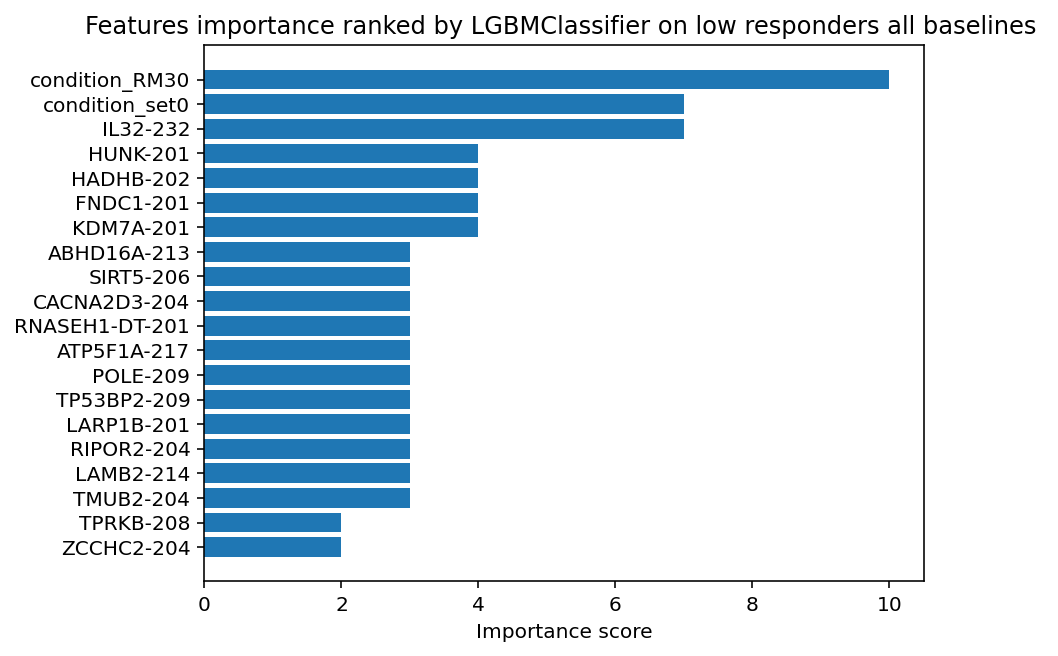

In [31]:
#Extract the important features in the high low object
all_baseline_imp4 = functions.imp_features(lgbm_clf4)

# plot the top 20 important features 
top_20 = all_baseline_imp4.iloc[-20:, :]
plt.title('Features importance ranked by LGBMClassifier on low responders all baselines ')
plt.xlabel('Importance score')
plt.gcf().set_dpi(145)
plt.barh(top_20['Features'],top_20['Importance_values'], height=0.8)
#plt.savefig(".\images\LGBMClassifier_top_20.png")
plt.show()


### Predicting for mid responders

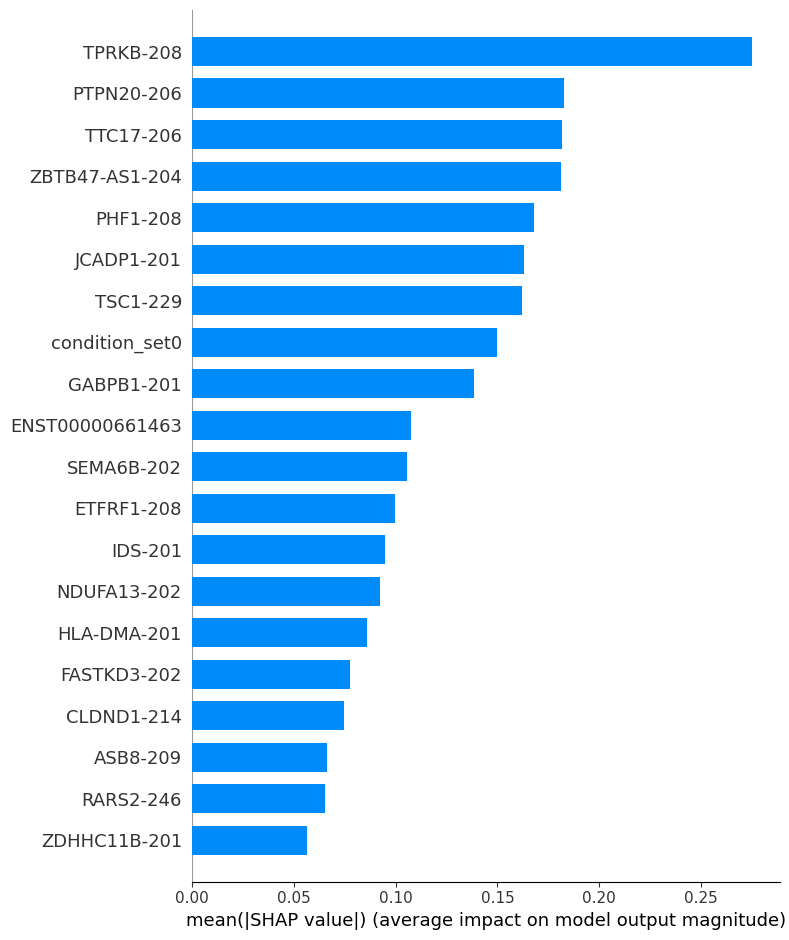

In [32]:
#predict on mid responders 
lgbm_clf3 = LGBMClassifier(is_unbalance=True,random_state=123, num_leaves = 3)
lgbm_clf3.fit(X, y_mid_cat)
y_pred=lgbm_clf3.predict(X)



#Explain the output using shap
explainer = shap.TreeExplainer(lgbm_clf3,X)
shap_values = explainer.shap_values(X)
shap.summary_plot(shap_values,X,plot_type="bar", max_display=20, class_names=y_mid_cat.unique())


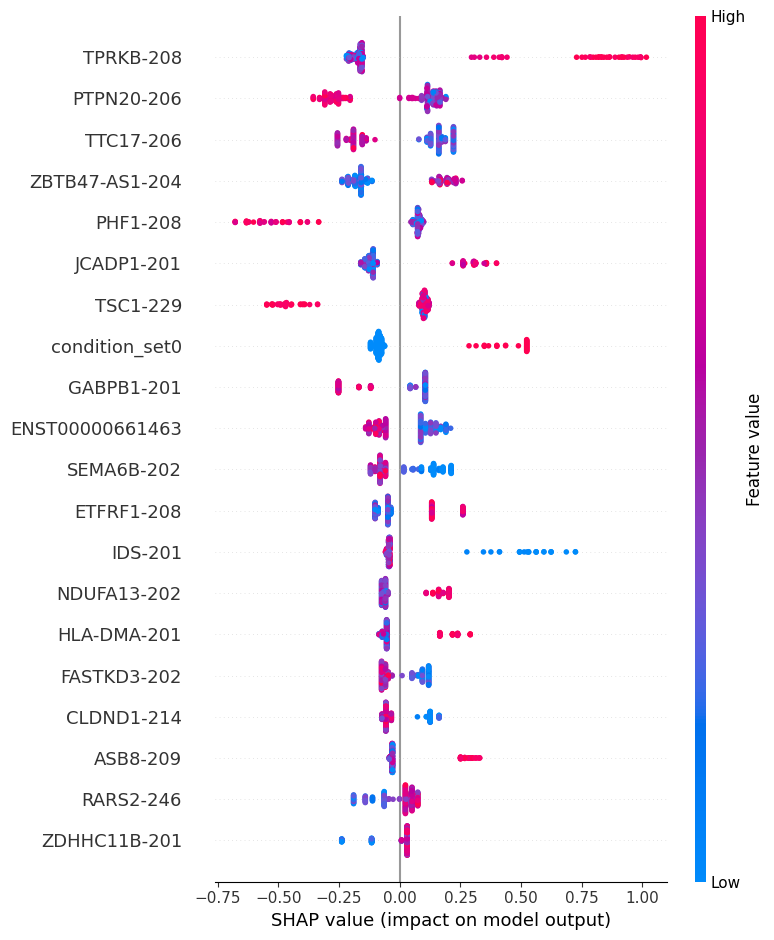

In [33]:
shap.summary_plot(shap_values,X,max_display=20, class_names=y_mid_cat.unique())

In [34]:
print("Accuracy", accuracy_score(y_mid_cat, y_pred))
print("Balanced accuracy", balanced_accuracy_score(y_mid_cat, y_pred))

print('F1 score:',f1_score(y_mid_cat,y_pred,average='weighted'))
print('MCC:', matthews_corrcoef(y_mid_cat,y_pred))

print(confusion_matrix(y_mid_cat,y_pred))

Accuracy 0.8711111111111111
Balanced accuracy 0.8712660028449501
F1 score: 0.8711111111111111
MCC: 0.7425320056899004
[[98 16]
 [13 98]]


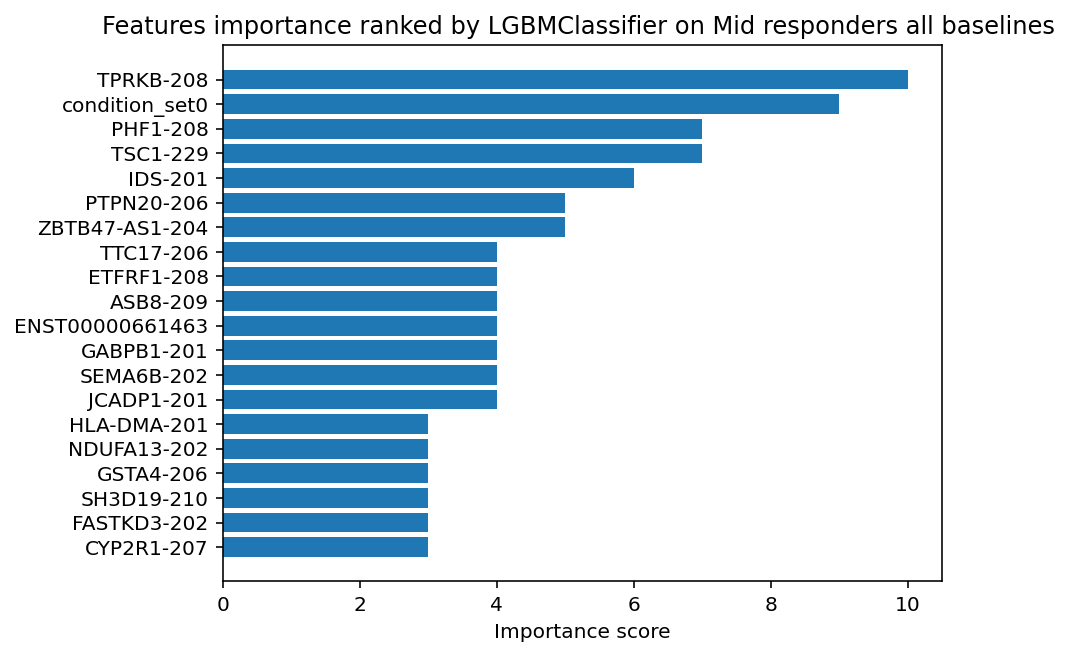

In [35]:
#Extract the important features in the high responders object
all_baseline_imp3 = functions.imp_features(lgbm_clf3)

# plot the top 20 important features 
top_20 = all_baseline_imp3.iloc[-20:, :]
plt.title('Features importance ranked by LGBMClassifier on Mid responders all baselines ')
plt.xlabel('Importance score')
plt.gcf().set_dpi(145)
plt.barh(top_20['Features'],top_20['Importance_values'], height=0.8)
plt.show()

### Are we really interested in the mid responders ?

### Extracting the important features

I will be extracting the important features as predicted by LGBMClassifiers for all the models

In [36]:
print("The number of important features for predicting all the categories is :", len(all_baseline_imp))
print("The number of important features for predicting high responders is :", len(all_baseline_imp2))
print("The number of important features for predicting low responders is :", len(all_baseline_imp4))
print("The number of important features for predicting mid responders is :", len(all_baseline_imp3))

The number of important features for predicting all the categories is : 272
The number of important features for predicting high responders is : 111
The number of important features for predicting low responders is : 119
The number of important features for predicting mid responders is : 104


Extracting these features into one numpy array. Some features will appear in more than one of the ranking dataframes with different importance score

In [37]:
#np.union1D takes only two arguements, thus the extraction of immportant features will be done sequentially
important_features = np.union1d(all_baseline_imp["Features"], all_baseline_imp2["Features"])
important_features = np.union1d(important_features, all_baseline_imp3["Features"])
important_features = np.union1d(important_features, all_baseline_imp4["Features"])
len(important_features)

465

In [38]:
#Print out the important features.
important_features

array(['ABCB7-202', 'ABCF2-H2BE1-201', 'ABHD16A-213', 'ABO-201',
       'ACO1-201', 'ACOT13-203', 'ACP1-201', 'ACSL1-209', 'ACSM5-205',
       'ACTR2-202', 'ADAM9-211', 'ADGRL2-212', 'ADGRL4-201', 'ADRA2B-201',
       'AFMID-214', 'AHCYL1-204', 'AKR1C1-202', 'ALG1-201', 'ALKBH4-201',
       'ALMS1-208', 'AMZ2-208', 'ANAPC1-201', 'ANKH-201', 'ANKLE2-207',
       'ANKRD10-210', 'ANKRD27-201', 'ANKRD33B-201', 'ANO5-214',
       'ANXA11-207', 'APLN-201', 'APOL5-201', 'APP-201', 'ARPIN-203',
       'ARSG-201', 'ART1-202', 'ASAH2-206', 'ASB8-201', 'ASB8-209',
       'ASB8-211', 'ASTN2-203', 'ATF3-206', 'ATMIN-206', 'ATP5F1A-217',
       'ATP6V0E1-204', 'BCAS3-222', 'BCAT2-201', 'BCL2-203', 'BCL6-202',
       'BMP2K-202', 'C11orf54-211', 'C1orf54-202', 'C2CD3-211',
       'C5orf51-201', 'CACNA2D3-204', 'CAMK2G-209', 'CARD8-AS1-201',
       'CASP3-206', 'CCDC134-201', 'CCDC159-210', 'CCDC47-204',
       'CCDC8-201', 'CCDC91-222', 'CCN1-203', 'CCN5-206', 'CCNDBP1-201',
       'CCR5-201', 'CCT2-

## Extracting these important features from the original gene isoforms dataframe

In [39]:
# assign the all_isoform dataframe to "important_transcripts" and set the index to "sample_id"
#this should make it easier to filter the important transcripts
important_transcripts = all_isoforms.set_index("sample_id")

#filter important transcripts as predicted by LGBMClassifier
important_transcripts = important_transcripts.filter(important_features)

#reset the index and reassing the column as "sample_id"
important_transcripts  = important_transcripts .reset_index()
important_transcripts  = important_transcripts .rename(columns = {"index": "sample_id"})
important_transcripts


transcript_id,sample_id,ABCB7-202,ABCF2-H2BE1-201,ABHD16A-213,ABO-201,ACO1-201,ACOT13-203,ACP1-201,ACSL1-209,ACSM5-205,...,ZNF3-203,ZNF330-202,ZNF37A-206,ZNF384-213,ZNF385D-201,ZNF517-202,ZNF74-207,ZNF76-206,ZNF777-201,ZSWIM7-212
0,X1023WVLL11,0.00,17.75,0.71,1.94,2.14,2.11,26.19,13.20,1.74,...,0.00,1.19,0.50,1.74,2.93,0.47,1.21,0.33,3.53,0.00
1,X1023WVLR10,1.14,17.34,0.66,2.63,4.23,0.00,27.36,17.54,1.13,...,1.53,1.23,0.44,1.95,4.16,0.00,1.30,0.28,2.63,0.00
2,X102PostExcVLL14,3.99,19.47,0.79,1.94,3.32,1.23,36.62,5.72,1.14,...,0.00,0.55,0.00,0.43,2.33,0.86,0.32,0.58,2.12,1.10
3,X102PostExcVLR13,2.58,11.43,0.21,4.73,6.42,5.50,25.51,21.41,1.47,...,1.98,1.60,0.22,2.65,5.14,0.82,1.25,0.34,3.50,1.28
4,X102PreExcVLR12,0.00,15.99,0.46,2.07,5.87,1.25,28.91,10.15,1.00,...,0.00,0.41,0.00,1.58,3.46,0.00,0.00,0.25,1.38,0.07
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
613,X95.subj4sample3,0.60,20.61,0.18,1.37,6.29,3.91,25.65,6.87,0.49,...,0.68,0.73,0.40,0.80,2.99,0.36,0.29,0.36,3.20,0.65
614,X96.subj4sample6,2.56,11.28,0.59,1.99,5.14,5.02,25.32,7.04,0.82,...,0.80,1.21,0.31,1.87,4.31,1.14,0.46,0.28,2.38,0.81
615,X97.subj4sample8,5.26,14.32,0.21,1.18,4.34,3.73,27.73,8.88,0.13,...,0.86,1.44,0.00,1.28,2.40,0.51,0.40,0.88,1.79,0.39
616,X98.subj40sample7,2.06,14.89,0.20,1.33,5.95,4.47,28.62,2.89,0.34,...,0.68,0.52,0.11,1.31,3.71,0.28,0.22,0.07,3.49,0.80


 Of the 32,517 transcripts, LGBMClassifier predicts 463 as important in determining an individual's response category

### Repeating the prediction process 
I have checked for publications that used ML for feature extraction. Have not yet seen any but I am wondering if there exists a reason why this cannot be done

In [40]:
#Repeat the process of merging with metadata again and training a model with the important features alone.
extracted_df = metadata.merge(important_transcripts, on = ["sample_id"])
#check for and remove missing values
extracted_df = extracted_df.dropna()
extracted_df

,participant,sample_id,sex,condition,study,age,height,weight,pct_change,diagnosis,...,ZNF3-203,ZNF330-202,ZNF37A-206,ZNF384-213,ZNF385D-201,ZNF517-202,ZNF74-207,ZNF76-206,ZNF777-201,ZSWIM7-212
0,FP102,X102PreExcVLR12,female,RM30,copd,65.80,151.50,84.00,22.21,none,...,0.00,0.41,0.00,1.58,3.46,0.00,0.00,0.25,1.38,0.07
1,FP102,X102PreExcVLR12,female,RM10,copd,65.80,151.50,84.00,17.24,none,...,0.00,0.41,0.00,1.58,3.46,0.00,0.00,0.25,1.38,0.07
2,FP103,X103PreExcVLR23,male,RM10,copd,70.90,170.00,82.50,1.05,none,...,2.97,0.96,0.40,1.28,1.64,0.20,1.44,0.86,3.01,0.76
3,FP103,X103PreExcVLR23,male,RM30,copd,70.90,170.00,82.50,14.01,none,...,2.97,0.96,0.40,1.28,1.64,0.20,1.44,0.86,3.01,0.76
4,FP105,X105PreExcVLR38,female,RM30,copd,67.00,162.50,65.00,12.05,none,...,1.26,1.02,0.40,0.00,1.84,0.20,0.30,0.34,1.00,1.30
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
222,FP6,FP6w0R,female,single,vol,21.80,156.00,50.00,-0.81,none,...,1.47,0.00,0.10,2.17,4.70,0.00,0.64,0.47,2.51,0.21
223,FP7,FP7w0L,male,multiple,vol,21.20,194.00,106.00,8.34,none,...,0.64,0.72,0.53,1.26,4.33,0.10,0.00,0.26,2.07,0.19
224,FP7,FP7w0R,male,single,vol,21.20,194.00,106.00,11.31,none,...,2.52,0.54,0.20,2.15,2.59,0.38,0.11,0.18,1.63,0.12
225,FP9,FP9w0L,male,single,vol,20.60,190.00,76.50,4.26,none,...,1.00,1.76,0.19,1.35,2.38,0.09,0.45,0.10,2.66,1.37


In [41]:
# initialize the X and y variables

X = functions.predictor_df(extracted_df)

y = functions.response_df(extracted_df)


In [42]:
X

,age,height,weight,ABCB7-202,ABCF2-H2BE1-201,ABHD16A-213,ABO-201,ACO1-201,ACOT13-203,ACP1-201,...,condition_RM10,condition_RM30,condition_multiple,condition_set0,condition_set3,condition_set6,condition_single,study_copd,study_ct,study_vol
0,0.92,-2.38,0.73,-1.19,0.39,0.59,1.12,0.14,-1.47,0.92,...,-0.58,1.70,-0.35,-0.44,-0.26,-0.22,-0.35,0.98,-0.60,-0.53
1,0.92,-2.38,0.73,-1.19,0.39,0.59,1.12,0.14,-1.47,0.92,...,1.72,-0.59,-0.35,-0.44,-0.26,-0.22,-0.35,0.98,-0.60,-0.53
2,1.06,-0.28,0.64,0.78,-0.00,-1.29,-1.34,0.06,-2.63,0.40,...,1.72,-0.59,-0.35,-0.44,-0.26,-0.22,-0.35,0.98,-0.60,-0.53
3,1.06,-0.28,0.64,0.78,-0.00,-1.29,-1.34,0.06,-2.63,0.40,...,-0.58,1.70,-0.35,-0.44,-0.26,-0.22,-0.35,0.98,-0.60,-0.53
4,0.95,-1.10,-0.58,-1.19,-0.04,-1.29,-1.73,-0.41,0.39,1.59,...,-0.58,1.70,-0.35,-0.44,-0.26,-0.22,-0.35,0.98,-0.60,-0.53
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
222,-1.14,-1.85,-1.92,1.60,-0.49,0.48,0.88,-0.02,-0.22,-0.23,...,-0.58,-0.59,-0.35,-0.44,-0.26,-0.22,2.83,-1.02,-0.60,1.87
223,-1.19,2.14,1.93,0.77,-1.06,1.20,-0.69,1.54,-1.52,0.07,...,-0.58,-0.59,2.83,-0.44,-0.26,-0.22,-0.35,-1.02,-0.60,1.87
224,-1.19,2.14,1.93,0.73,-1.00,-0.83,0.52,1.25,-0.70,0.81,...,-0.58,-0.59,-0.35,-0.44,-0.26,-0.22,2.83,-1.02,-0.60,1.87
225,-1.24,1.76,0.25,-1.19,-1.62,-1.29,-0.36,-0.79,-0.00,-0.49,...,-0.58,-0.59,-0.35,-0.44,-0.26,-0.22,2.83,-1.02,-0.60,1.87


In [43]:
y.unique()

array(['High_responder', 'mid_responder', 'Low_responder'], dtype=object)

In [44]:
#split into train and test. Test set will be 20% of the data
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                test_size=.25,random_state =123)

#Use Lazy classifier to predict suitable ML models
clf = LazyClassifier(verbose=0,ignore_warnings=True, custom_metric=None)
models, predictions = clf.fit(X_train, X_test, y_train, y_test)
models


100%|██████████| 29/29 [00:03<00:00,  7.69it/s]


,Accuracy,Balanced Accuracy,ROC AUC,F1 Score,Time Taken
Model,,,,,
PassiveAggressiveClassifier,0.70,0.74,None,0.70,0.03
Perceptron,0.72,0.73,None,0.72,0.02
LinearDiscriminantAnalysis,0.74,0.72,None,0.74,0.04
LogisticRegression,0.74,0.72,None,0.74,0.05
GaussianNB,0.67,0.71,None,0.66,0.02
SGDClassifier,0.70,0.70,None,0.70,0.03
RidgeClassifierCV,0.68,0.69,None,0.69,0.03
RidgeClassifier,0.68,0.69,None,0.69,0.02
LinearSVC,0.67,0.69,None,0.67,0.28


PassiveAggressiveClassifier is ranked highly here

In [45]:
pac_clf = PassiveAggressiveClassifier(random_state=123, early_stopping = True, validation_fraction= 0.25)
pac_clf.fit(X_train, y_train)
y_pred = pac_clf.predict(X_test)

In [46]:
print("Accuracy", accuracy_score(y_test, y_pred))
print("Balanced accuracy", balanced_accuracy_score(y_test, y_pred))
print('F1 score:',f1_score(y_test,y_pred,average='weighted'))
print('MCC:', matthews_corrcoef(y_test,y_pred))

print(confusion_matrix(y_test,y_pred))

Accuracy 0.631578947368421
Balanced accuracy 0.72831541218638
F1 score: 0.62293510162557
MCC: 0.5038179349229589
[[11  0  0]
 [ 2 11  2]
 [ 9  8 14]]


In [47]:
## Checking if LGBMClassifier will give a better output
lgb_class = LGBMClassifier(random_state=123, num_leaves= 3, objective = "multiclass")
lgb_class.fit(X_train, y_train)
lgb_pred = lgb_class.predict(X_test)

In [48]:
print("Accuracy", accuracy_score(y_test, lgb_pred))
print("Balanced accuracy", balanced_accuracy_score(y_test,lgb_pred))
print('F1 score:',f1_score(y_test,lgb_pred,average='weighted'))
print('MCC:', matthews_corrcoef(y_test,lgb_pred))

print(confusion_matrix(y_test,lgb_pred))

Accuracy 0.7543859649122807
Balanced accuracy 0.7381557510589768
F1 score: 0.7469785575048733
MCC: 0.5816983684156329
[[10  0  1]
 [ 1  7  7]
 [ 0  5 26]]
